#IMPORT

In [ ]:
import sklearn as sk 
import os 
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math
from datetime import datetime
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

from tqdm import tqdm

import seaborn as sns
sns.set(rc={'figure.figsize':(20,10)})
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from numpy import log 


!python --version 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Python 3.7.12


# DRIVE

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/MyDrive/ProgettoDS'
os.listdir(path)

Mounted at /content/drive


['continuous dataset.csv', 'wordcloud.png']

# Read CSV & Transform Date to Series  

In [ ]:
dtypes={
    'datetime' : 'str',
    'nat_demand' :'float',
    'T2M_toc' : 'float',
    'QV2M_toc' : 'float',
    'TQL_toc' : 'float',
    'W2M_toc' : 'float',
    'T2M_san' : 'float',
    'QV2M_san' : 'float',
    'TQL_san' : 'float',
    'W2M_san' : 'float',
    'T2M_dav' : 'float',
    'QV2M_dav' : 'float',
    'TQL_dav' : 'float',
    'W2M_dav' : 'float',
    'Holiday_ID' : 'int64',
    'holiday' : 'boolean',
    'school' : 'boolean'
}

dataframe = pd.read_csv('/content/drive/MyDrive/ProgettoDS/continuous dataset.csv', sep=',' , header=0, dtype=dtypes)
print('N° Elementi : {}'.format(len(dataframe)))

cols = dataframe.columns.to_numpy()
cols = np.append(cols, ['timeseries' , 'year', 'quarter', 'data'])
df_time = pd.DataFrame(columns=cols) 

i = 0
for index, row in tqdm(dataframe.iterrows()):  
  #print(row['datetime'])
  year = row['datetime'].split(sep='-')[0]
  quarter = int(row['datetime'].split(sep='-')[1])//4+1
  index_ = ('{}Q{}').format(year, quarter) 
  date_split = row['datetime'].split(sep='-')
  data = '{}-{}-{}'.format(date_split[0], date_split[1], date_split[2].split(sep=' ')[0])
  row = row.append(pd.Series({'timeseries':index_ , 'year' : year , 'quarter' : quarter , 'data' : pd.to_datetime(data)}))
  df_time = df_time.append(row, ignore_index=True)
  date_split = row['datetime'].split(sep='-')
  data = '{}-{}-{}'.format(date_split[0], date_split[1], date_split[2].split(sep=' ')[0])
  row['datetime'] = data
  
  #per limitare ... commentare a fine progetto
  #i += 1 
  #if i >1500:
  #  break


print('\n')
print(df_time)
print('fine')

N° Elementi : 48048


48048it [14:32, 55.10it/s]




                  datetime  nat_demand    T2M_toc  ...  year  quarter       data
0      2015-01-03 01:00:00    970.3450  25.865259  ...  2015        1 2015-01-03
1      2015-01-03 02:00:00    912.1755  25.899255  ...  2015        1 2015-01-03
2      2015-01-03 03:00:00    900.2688  25.937280  ...  2015        1 2015-01-03
3      2015-01-03 04:00:00    889.9538  25.957544  ...  2015        1 2015-01-03
4      2015-01-03 05:00:00    893.6865  25.973840  ...  2015        1 2015-01-03
...                    ...         ...        ...  ...   ...      ...        ...
48043  2020-06-26 20:00:00   1128.5592  27.246545  ...  2020        2 2020-06-26
48044  2020-06-26 21:00:00   1112.7488  27.099573  ...  2020        2 2020-06-26
48045  2020-06-26 22:00:00   1081.5680  26.971155  ...  2020        2 2020-06-26
48046  2020-06-26 23:00:00   1041.6240  26.867487  ...  2020        2 2020-06-26
48047  2020-06-27 00:00:00   1013.5683  26.750330  ...  2020        2 2020-06-27

[48048 rows x 21 columns]

In [ ]:
#print('numero di elementi del dataset : {}'.format(len(df_time)))
#print('numero elementi univoci : {}'.format(len(df_time['nat_demand'].unique())))
#print('mean nat demand : {}'.format(np.mean(df_time['nat_demand'])))
#print('max nat demand : {}'.format(np.max(df_time['nat_demand'])))
#print('min nat demand : {}'.format(np.min(df_time['nat_demand'])))
#print(df_time['nat_demand'].unique())
'''
def segment(value, numsplits):
    return ["{}-{}".format(
        int(round(1 + i * value/(numsplits*1.0),0)),
        int(round(1 + i * value/(numsplits*1.0) +
              value/(numsplits*1.0)-1, 0))) for
        i in range(numsplits)]

print(segment(np.max(df_time['nat_demand']), 5)) #range possibili 

df_time.loc[(df_time.nat_demand <= 351),'nat_demand']= 351
df_time.loc[(df_time.nat_demand >351) & (df_time.nat_demand <=702), "nat_demand"] = 702
df_time.loc[(df_time.nat_demand >703) & (df_time.nat_demand <=1053), "nat_demand"] = 1053
df_time.loc[(df_time.nat_demand >1054) & (df_time.nat_demand <=1404), "nat_demand"] = 1404
df_time.loc[(df_time.nat_demand > 1405), "nat_demand"] = 1755
print('----------------------')
print(df_time['nat_demand'].unique())
'''
#df_time['nat_demand'] = df_time.nat_demand.astype(int)
#print(df_time['nat_demand'].unique())
#df_time.head()

'\ndef segment(value, numsplits):\n    return ["{}-{}".format(\n        int(round(1 + i * value/(numsplits*1.0),0)),\n        int(round(1 + i * value/(numsplits*1.0) +\n              value/(numsplits*1.0)-1, 0))) for\n        i in range(numsplits)]\n\nprint(segment(np.max(df_time[\'nat_demand\']), 5)) #range possibili \n\ndf_time.loc[(df_time.nat_demand <= 351),\'nat_demand\']= 351\ndf_time.loc[(df_time.nat_demand >351) & (df_time.nat_demand <=702), "nat_demand"] = 702\ndf_time.loc[(df_time.nat_demand >703) & (df_time.nat_demand <=1053), "nat_demand"] = 1053\ndf_time.loc[(df_time.nat_demand >1054) & (df_time.nat_demand <=1404), "nat_demand"] = 1404\ndf_time.loc[(df_time.nat_demand > 1405), "nat_demand"] = 1755\nprint(\'----------------------\')\nprint(df_time[\'nat_demand\'].unique())\n'

## Period Range

In [ ]:
df_time['datetime'] = pd.to_datetime(df_time['datetime']).dt.to_period('H')
idx = pd.period_range(df_time['datetime'].min(), df_time['datetime'].max(), freq='H')
df_time = df_time.set_index('datetime').reindex(idx, fill_value=0)
print(df_time)

                  nat_demand    T2M_toc  QV2M_toc  ...  year  quarter       data
2015-01-03 01:00    970.3450  25.865259  0.018576  ...  2015        1 2015-01-03
2015-01-03 02:00    912.1755  25.899255  0.018653  ...  2015        1 2015-01-03
2015-01-03 03:00    900.2688  25.937280  0.018768  ...  2015        1 2015-01-03
2015-01-03 04:00    889.9538  25.957544  0.018890  ...  2015        1 2015-01-03
2015-01-03 05:00    893.6865  25.973840  0.018981  ...  2015        1 2015-01-03
...                      ...        ...       ...  ...   ...      ...        ...
2020-06-26 20:00   1128.5592  27.246545  0.020303  ...  2020        2 2020-06-26
2020-06-26 21:00   1112.7488  27.099573  0.020395  ...  2020        2 2020-06-26
2020-06-26 22:00   1081.5680  26.971155  0.020448  ...  2020        2 2020-06-26
2020-06-26 23:00   1041.6240  26.867487  0.020464  ...  2020        2 2020-06-26
2020-06-27 00:00   1013.5683  26.750330  0.020441  ...  2020        2 2020-06-27

[48048 rows x 20 columns]


#Inspect Dataset


## Parameters 

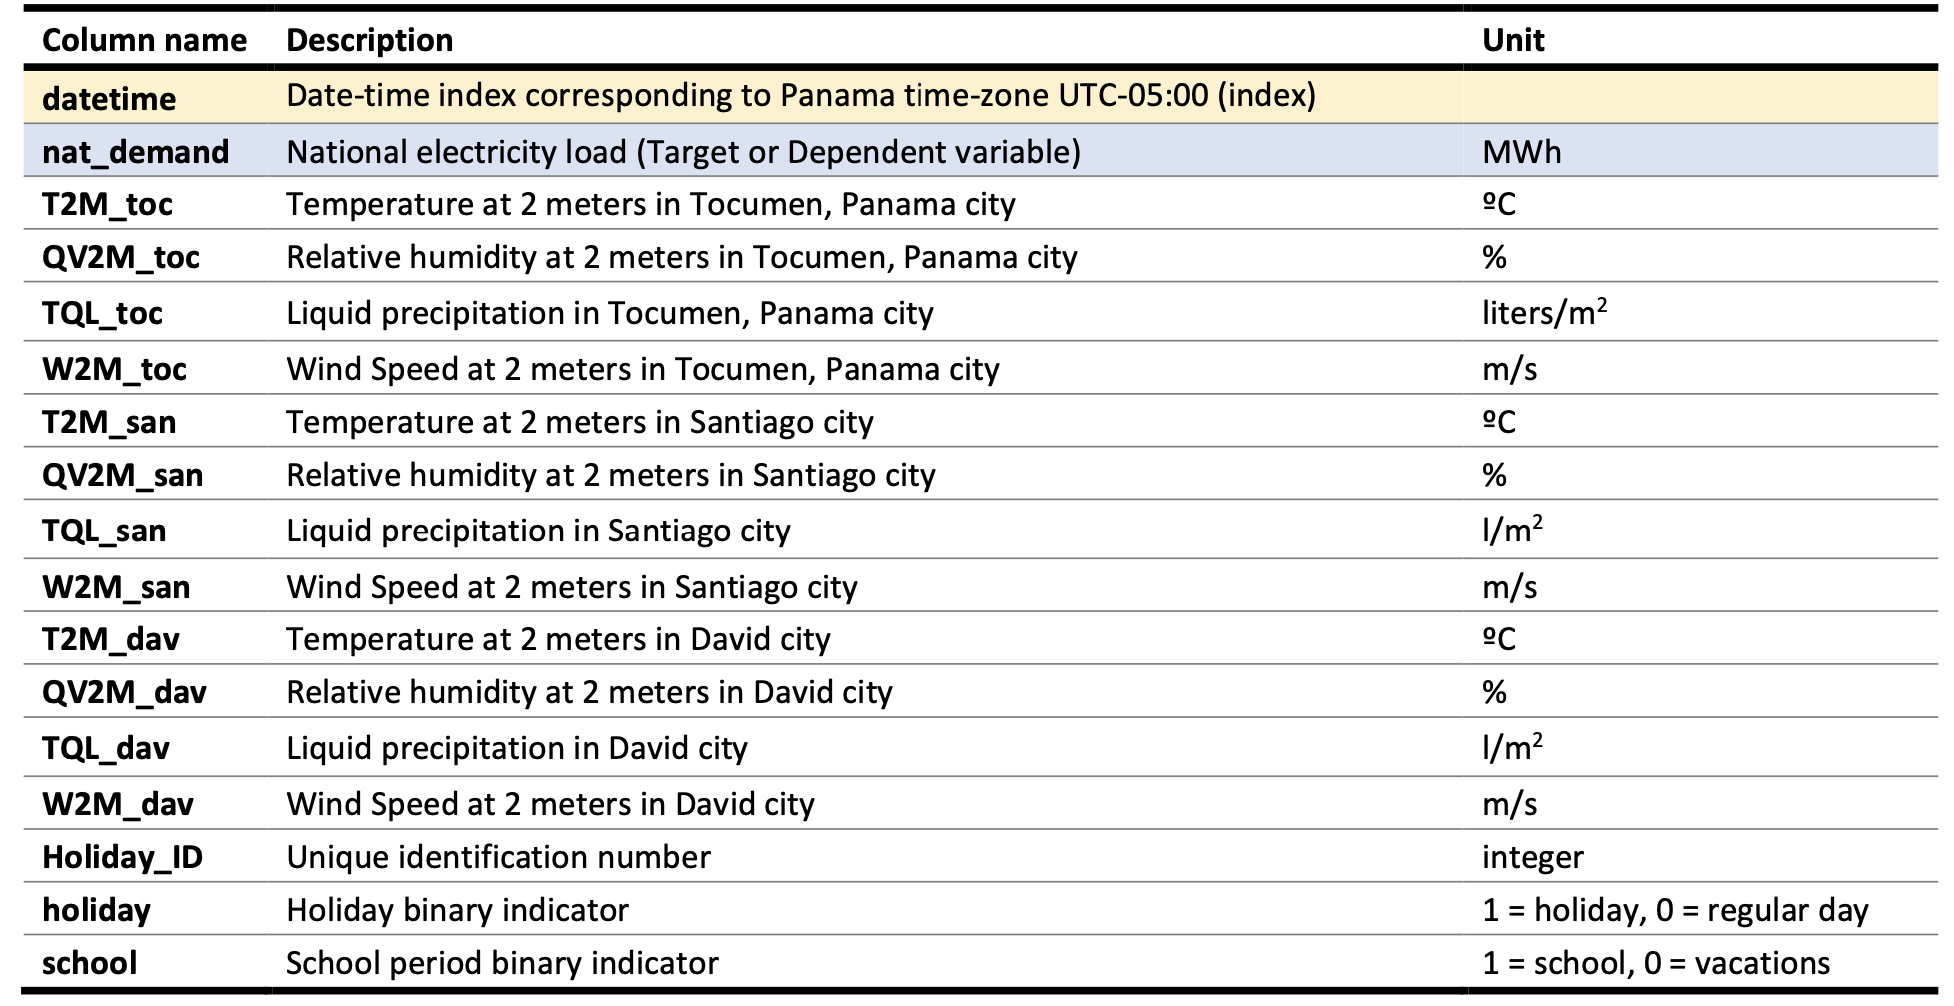

## Plot to Inspect Data Frame (Tocumen, Panama City) 
* TQL_toc = Precipitazione a Tocumen 
* QV2M_toc = Umidità a Tocumen 
* T2M_toc = Temperatura a Tocumen 
* W2M_toc = Vento 

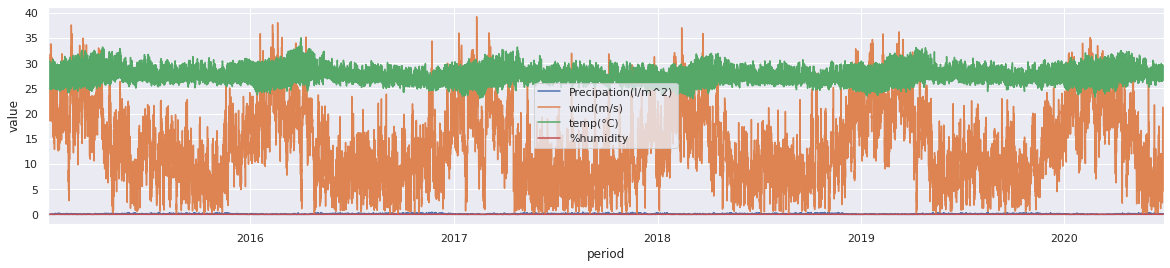

In [ ]:
df = pd.DataFrame(df_time, index=df_time.index, columns=['TQL_toc', 'W2M_toc', 'T2M_toc', 'QV2M_toc'])
df.plot(ylabel='value', xlabel='period' , figsize=(20,4))
plt.legend(['Precipation(l/m^2)', 'wind(m/s)', 'temp(°C)', '%humidity'])

In [ ]:
df_time['TQL_toc'].mean()

0.0799793602294157

## Plot to Inspect Data Frame (Santiago, Panama City) 
* TQL_san = Precipitazione a Tocumen 
* QV2M_san = Umidità a Tocumen 
* T2M_san = Temperatura a Tocumen 
* W2M_san = Vento 

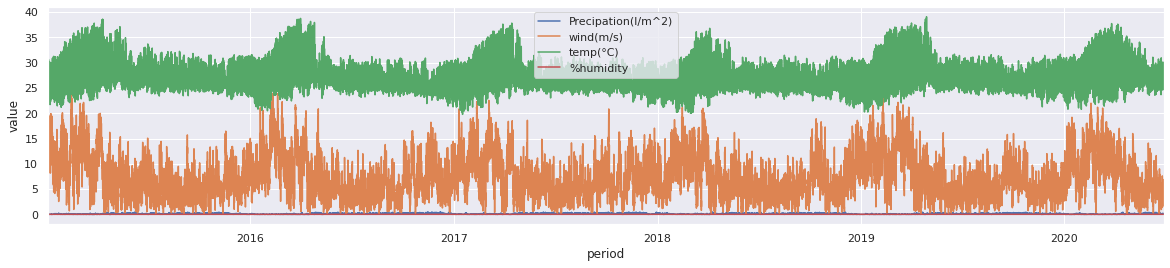

In [ ]:
df = pd.DataFrame(df_time, index=df_time.index, columns=['TQL_san', 'W2M_san', 'T2M_san', 'QV2M_san'])
df.plot(ylabel='value', xlabel='period', figsize=(20,4))
plt.legend(['Precipation(l/m^2)', 'wind(m/s)', 'temp(°C)', '%humidity'])


## Plot to Inspect Data Frame (David, Panama City) 
* TQL_dav = Precipitazione a Tocumen 
* QV2M_dav = Umidità a Tocumen 
* T2M_dav = Temperatura a Tocumen 
* W2M_dav = Vento 

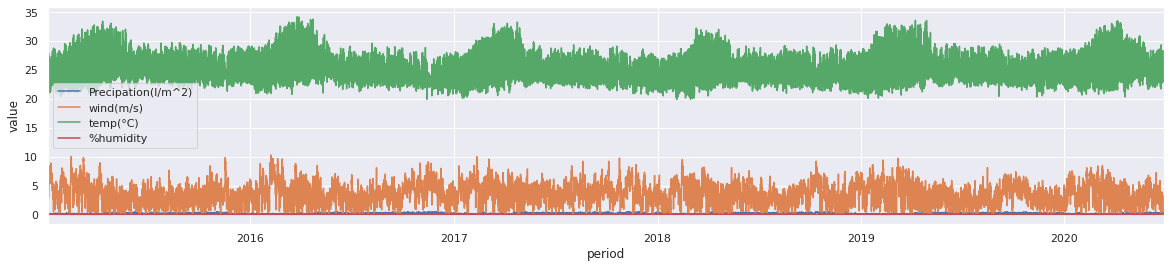

In [ ]:
df = pd.DataFrame(df_time, index=df_time.index, columns=['TQL_dav', 'W2M_dav', 'T2M_dav', 'QV2M_dav'])
df.plot(ylabel='value', xlabel='period', figsize=(20,4))
plt.legend(['Precipation(l/m^2)', 'wind(m/s)', 'temp(°C)', '%humidity'])

## Nat Demand (National electricity load) MWh

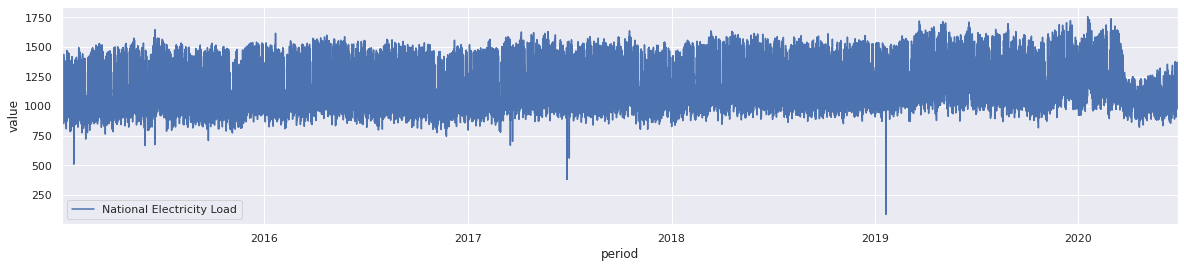

In [ ]:
df = pd.DataFrame(df_time, index=df_time.index, columns=['nat_demand'])
df.plot(ylabel='value', xlabel='period' ,  figsize=(20,4))
plt.legend(['National Electricity Load'])

# How Holiday & School Influence National Demand of Electricity (NON UTILIZZATO)


## Holidays ID

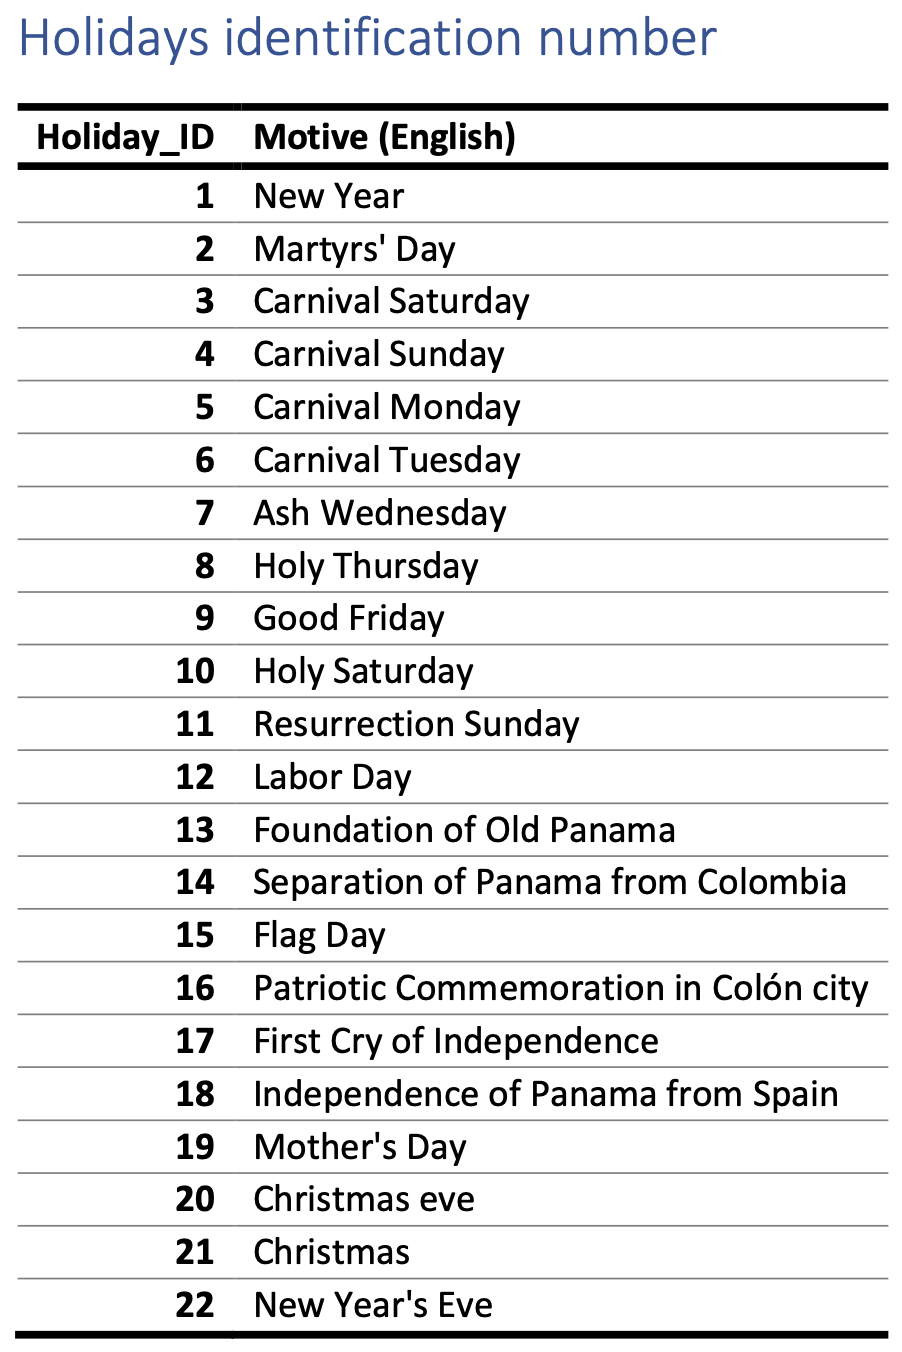

## How holiday influence National Demands of Electricity 

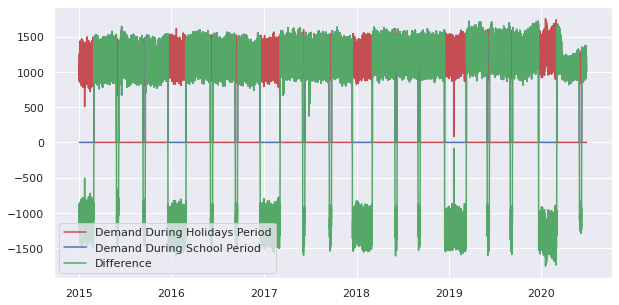

In [ ]:
df_time_school = df_time.copy(deep=True)
df_time_yes_school = df_time.copy(deep=True)
df_time_no_school = df_time.copy(deep=True)
df_time_yes_school['nat_demand'] = np.where(df_time_school['school'] == 1, df_time_school['nat_demand'], 0) #c'è scuola 
df_time_no_school['nat_demand'] = np.where(df_time_school['school'] == 0, df_time_school['nat_demand'], 0) #c'è scuola 

#print(df_time_yes_school['nat_demand'])
#print(df_time_no_school['nat_demand'])

df_result = df_time_yes_school['nat_demand'].values - df_time_no_school['nat_demand'].values#diff - #è la differenza tra l'utilizzo (nat demands) durante il periodo scolastico e il periodo di vacanze 
#print(df_result)
df_time_yes_school.values #l'utilizzo durante il periodo scolastico
df_time_no_school.values #l'utilizzo durante il periodo di vacanze

t = pd.to_datetime(df_time_school['data'])
a = df_time_no_school['nat_demand']
b = df_time_yes_school['nat_demand']
c = df_result

plt.figure(figsize=(10,5))
plt.legend('lower left')
plt.plot(t, a, 'r') # plotting t, a separately 
plt.plot(t, b, 'b') # plotting t, b separately 
plt.plot(t, c, 'g') # plotting t, c separately 
plt.legend(['Demand During Holidays Period', 'Demand During School Period','Difference'])
plt.show()

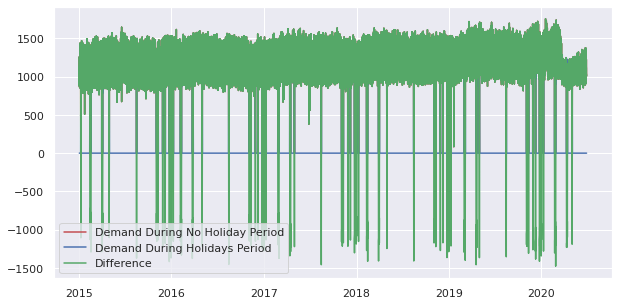

In [ ]:
df_time_holiday = df_time.copy(deep=True)
df_time_yes_holiday = df_time.copy(deep=True)
df_time_no_holiday = df_time.copy(deep=True)
df_time_yes_holiday['nat_demand'] = np.where(df_time_holiday['holiday'] == 1, df_time_school['nat_demand'], 0) 
df_time_no_holiday['nat_demand'] = np.where(df_time_holiday['holiday'] == 0, df_time_school['nat_demand'], 0)

#print(df_time_yes_holiday['nat_demand'])
#print(df_time_no_holiday['nat_demand'])

df_result =  df_time_no_holiday['nat_demand'].values -df_time_yes_holiday['nat_demand'].values  
#print(df_result)
df_time_yes_holiday.values #l'utilizzo durante il periodo scolastico
df_time_no_holiday.values #l'utilizzo durante il periodo di vacanze


t = pd.to_datetime(df_time_school['data'])
a = df_time_no_holiday['nat_demand']
b = df_time_yes_holiday['nat_demand']
c = df_result

plt.figure(figsize=(10,5))
plt.legend('lower left')
plt.plot(t, a, 'r') # plotting t, a separately 
plt.plot(t, b, 'b') # plotting t, b separately 
plt.plot(t, c, 'g') # plotting t, c separately 
plt.legend(['Demand During No Holiday Period','Demand During Holidays Period','Difference'])
plt.show()

# Pair Grid Chart 

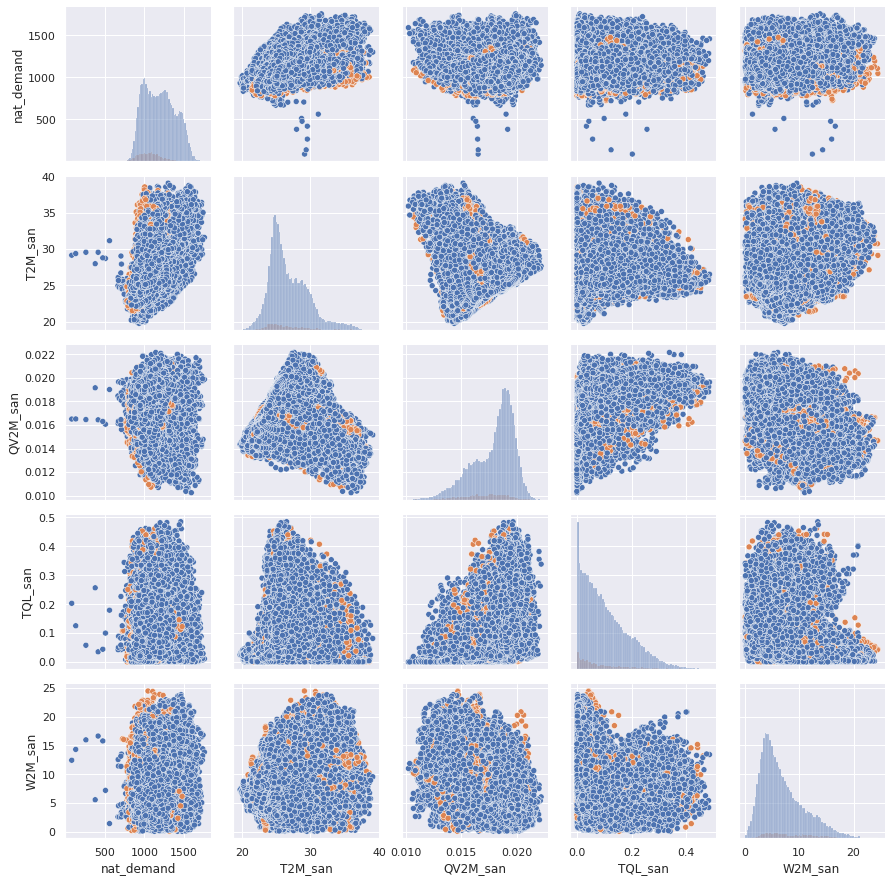

In [ ]:
import seaborn as sns
g = sns.PairGrid(df_time , vars =['nat_demand', 'T2M_san', 'QV2M_san' , 'TQL_san', 'W2M_san'], hue="holiday")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

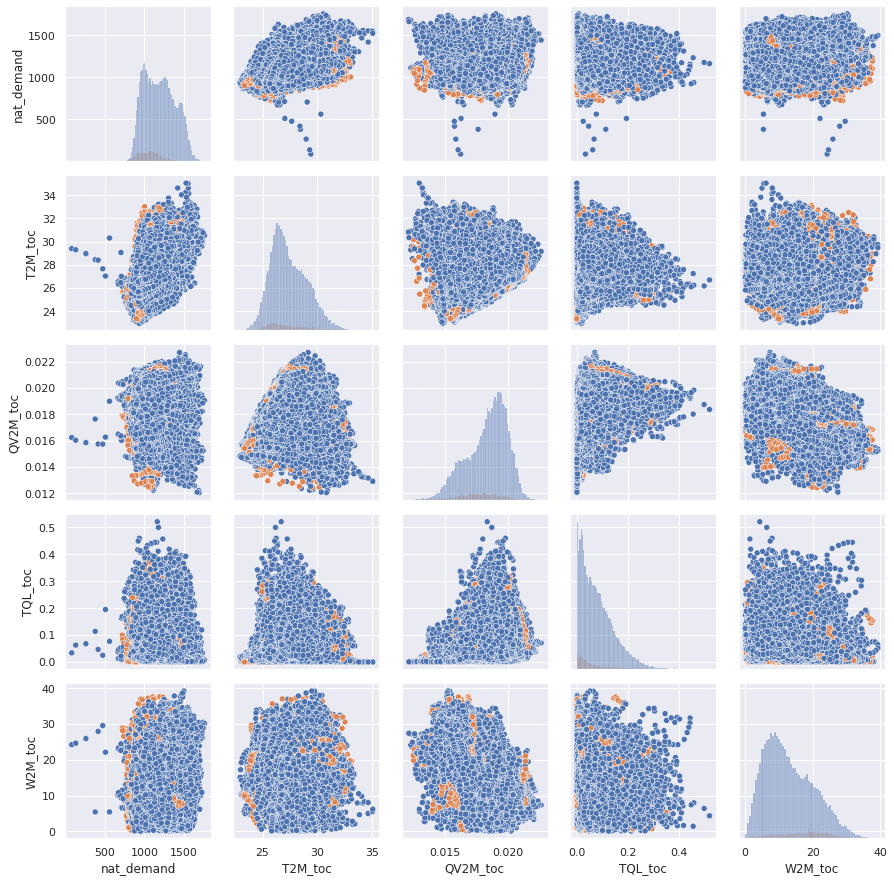

In [ ]:
g = sns.PairGrid(df_time , vars =['nat_demand', 'T2M_toc', 'QV2M_toc' , 'TQL_toc', 'W2M_toc'], hue="holiday" )
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)

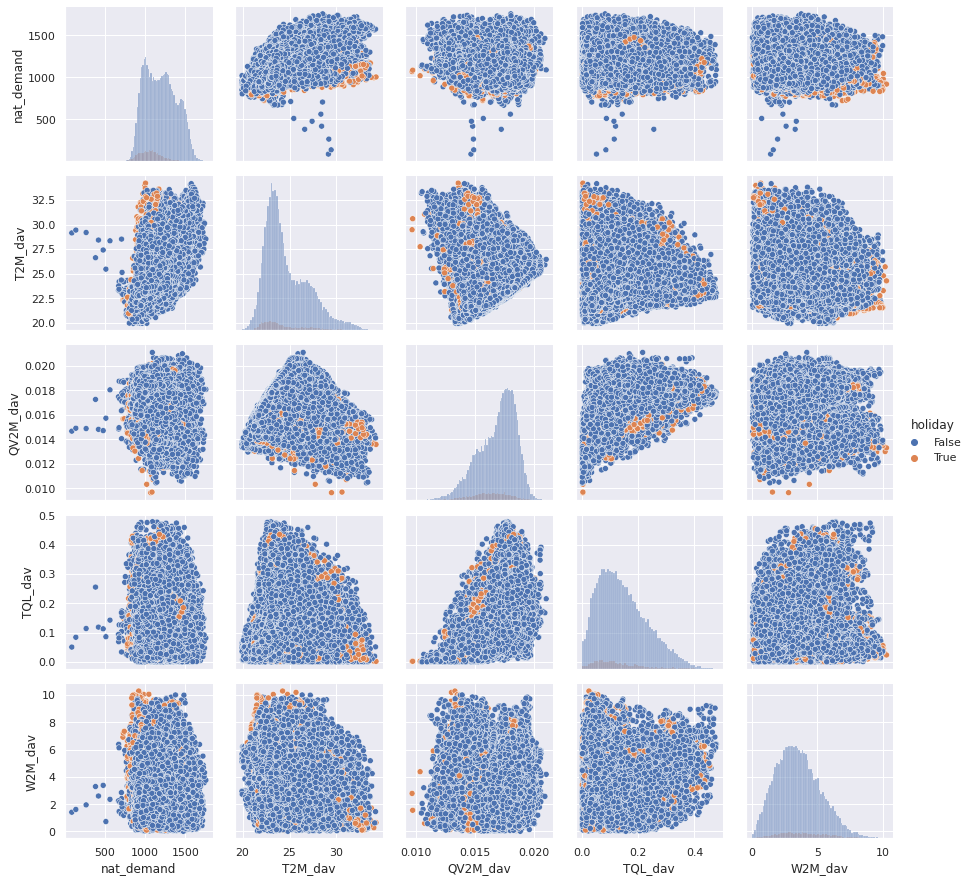

In [ ]:
g = sns.PairGrid(df_time , vars =['nat_demand', 'T2M_dav', 'QV2M_dav' , 'TQL_dav', 'W2M_dav'] , hue="holiday")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

In [ ]:
'''
import seaborn as sns

sns.set_theme();
sns.displot(df_time, x="nat_demand", col="holiday")

sns.displot(df_time, x="TQL_san", col="holiday")

sns.displot(df_time, x="TQL_toc", col="holiday")
'''

'\nimport seaborn as sns\n\nsns.set_theme();\nsns.displot(df_time, x="nat_demand", col="holiday")\n\nsns.displot(df_time, x="TQL_san", col="holiday")\n\nsns.displot(df_time, x="TQL_toc", col="holiday")\n'

# Distribution Plot over Time 

color : r
color : g
color : b
color : y
color : b
color : r
color : b
color : r
color : g
color : b
color : y
color : b


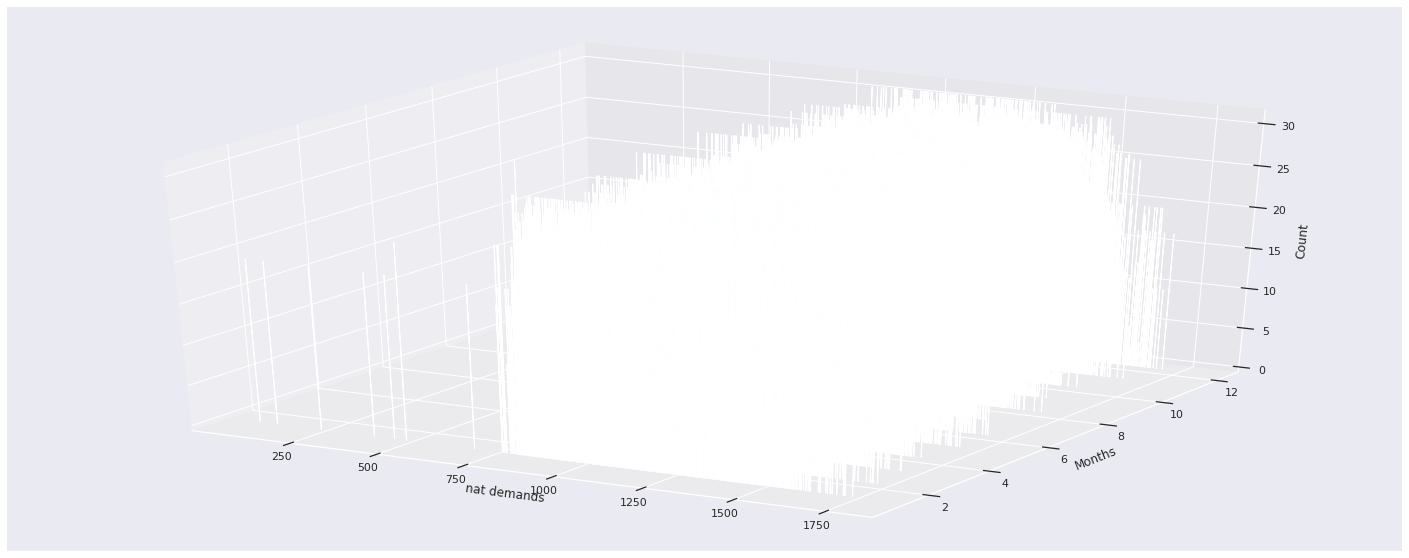

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(25,10)})

df_time_groups = df_time.groupby(df_time.data.dt.month)

for x in df_time_groups.groups:
  df = df_time_groups.get_group(x)
  #print(x)
  #print(df.columns)
  # plot lines
  #sns.displot(df.nat_demand, kind="kde", fill=True)
  #sns.displot(df.nat_demand, x=df.nat_demand, kde=True, fill=True)



"""
========================================
Create 2D bar graphs in different planes
========================================

Demonstrates making a 3D plot which has 2D bar graphs projected onto
planes y=0, y=1, etc.
"""

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def cc(arg):
    return mcolors.to_rgba(arg, alpha=0.6)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
months = np.array([i+1 for i in range(len(df_time_groups))])

months_ = np.array([i+1 for i in range(len(df_time_groups))])


k = 1
for x,y in zip(months, ['r', 'g', 'b', 'y', 'b', 'r', 'b', 'r', 'g', 'b', 'y', 'b', 'r', 'b']):
    df = df_time_groups.get_group(x)
    xs = df.nat_demand
    print('color : {}'.format(y))
    ys = df.data.dt.day

    cs = [y]
    cs[0] = 'c'

    ax.bar(xs, ys, zs=x, zdir='y', color=cs, alpha=1)
    k+=1

ax.set_xlabel('nat demands')
ax.set_ylabel('Months')
ax.set_zlabel('Count')

plt.show()

# Correlation Analysis

Pearson R : 0.6482789036320161 
Spearman R : 0.6997469274606011,  P-Value 0.0 
Kendall Tau : 0.5079872033529059, P-Value 0.0


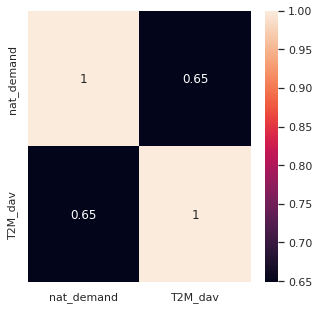

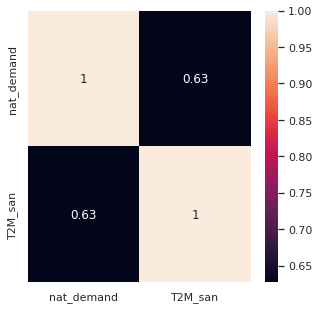

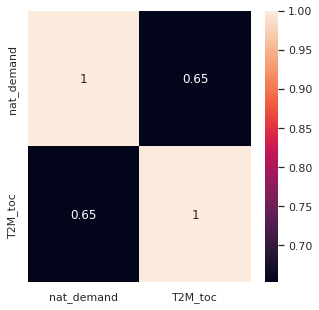

In [ ]:
#size of plot
sns.set(rc={'figure.figsize':(5,5)})

##########----Correllazione----############
import scipy.stats
pearson_r = scipy.stats.pearsonr(df_time['nat_demand'], df_time['T2M_dav'])
print('Pearson R : {} '.format(pearson_r[0]))    # Pearson's r

spermanr = scipy.stats.spearmanr(df_time['nat_demand'], df_time['T2M_dav'])
print('Spearman R : {},  P-Value {} '.format(spermanr[0], spermanr[1]))    # Spearman's r

kendalltau = scipy.stats.kendalltau(df_time['nat_demand'], df_time['T2M_dav'])
print('Kendall Tau : {}, P-Value {}'.format(kendalltau[0], kendalltau[1])) # Kendall's tau

#--------------corrcoef temperature & nat demand---------------
for x,y in zip((df_time['T2M_dav'], df_time['T2M_san'], df_time['T2M_toc']),['T2M_dav', 'T2M_san','T2M_toc'] ):
  #print(x)
  #print(y)
  r = np.corrcoef(df_time['nat_demand'], x)
  df_cm = pd.DataFrame(r, index = [i for i in ['nat_demand', y]],
                  columns = [i for i in ['nat_demand', y]])
  plt.figure(figsize = (5,5))
  sns.heatmap(df_cm, annot=True)
  #print(r)



# +0.8 to 1.0	Very strong + association
# +0.6 to 0.8	Strong + association


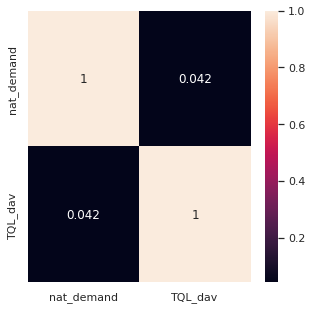

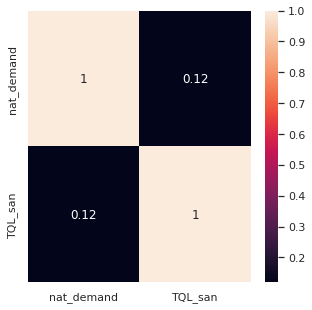

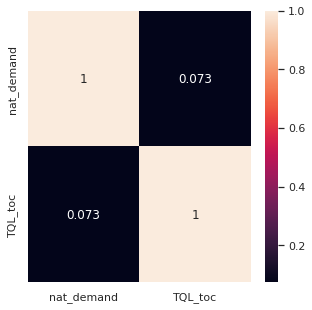

In [ ]:
#--------------corrcoef TQL & nat demand---------------
for x,y in zip((df_time['TQL_dav'], df_time['TQL_san'], df_time['TQL_toc']),['TQL_dav', 'TQL_san','TQL_toc'] ):
  #print(x)
  #print(y)
  r = np.corrcoef(df_time['nat_demand'], x)
  df_cm = pd.DataFrame(r, index = [i for i in ['nat_demand', y]],
                  columns = [i for i in ['nat_demand', y]])
  plt.figure(figsize = (5,5))
  sns.heatmap(df_cm, annot=True)
  #print(r)

# 0.0 to +0.2	Very weak + or no association
# 0.0 to -0.2	Very weak - or no association

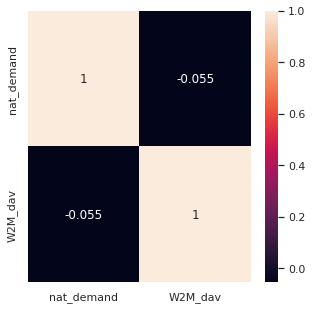

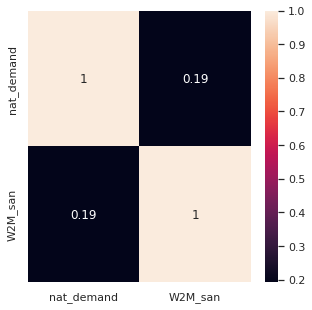

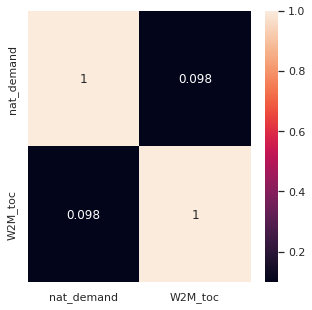

In [ ]:
#--------------corrcoef W2M & nat demand---------------
for x,y in zip((df_time['W2M_dav'], df_time['W2M_san'], df_time['W2M_toc']),['W2M_dav', 'W2M_san','W2M_toc'] ): 
  #print(x)
  #print(y)
  r = np.corrcoef(df_time['nat_demand'], x)
  df_cm = pd.DataFrame(r, index = [i for i in ['nat_demand', y]],
                  columns = [i for i in ['nat_demand', y]])
  plt.figure(figsize = (5,5))
  sns.heatmap(df_cm, annot=True)
  #print(r)


# +0.2 to 0.4	Weak + association
# 0.0 to +0.2	Very weak + or no association


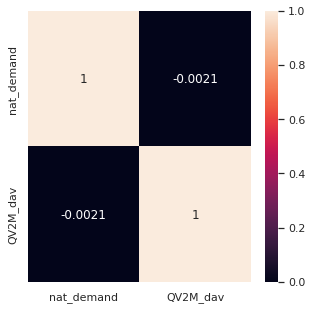

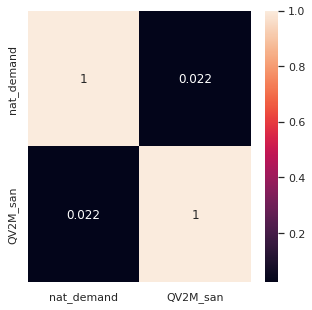

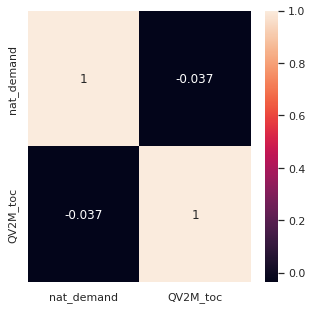

In [ ]:
#--------------corrcoef QV2M & nat demand---------------
for x,y in zip((df_time['QV2M_dav'], df_time['QV2M_san'], df_time['QV2M_toc']),['QV2M_dav', 'QV2M_san','QV2M_toc'] ): 
  #print(x)
  #print(y)
  r = np.corrcoef(df_time['nat_demand'], x)
  df_cm = pd.DataFrame(r, index = [i for i in ['nat_demand', y]],
                  columns = [i for i in ['nat_demand', y]])
  plt.figure(figsize = (5,5))
  sns.heatmap(df_cm, annot=True)
  #print(r)


# Scatter Plot & lowess

mean : 1182.8686472323818 stdv : 0.08789805971970156


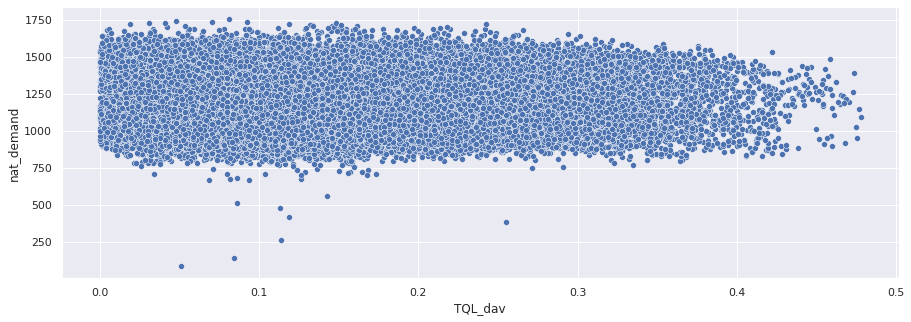

In [ ]:
sns.set(rc={'figure.figsize':(15,5)})
#--------std & mean--------
print('mean : {} stdv : {}'.format(np.mean(df_time['nat_demand']), np.std(df_time['TQL_dav'])))
#--------plot--------
sns.scatterplot(x=df_time['TQL_dav'], y=df_time['nat_demand'])

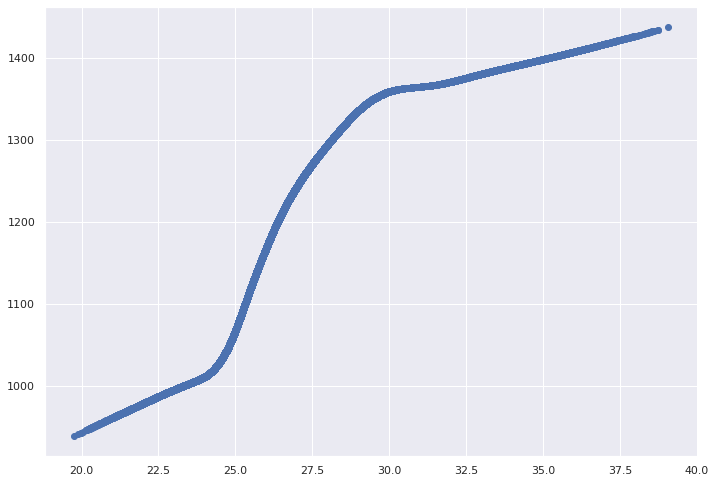

In [ ]:
import numpy as np
import statsmodels.api as sm 
lowess = sm.nonparametric.lowess
#x=df_time['TQL_dav']
#y=df_time['nat_demand']


x = df_time['nat_demand']
y = df_time['T2M_san']

z = lowess(x,y , frac=1./3)
plt.scatter(z[:,0], z[:,1])
plt.show()

mean=1182.869 stdv=3.018


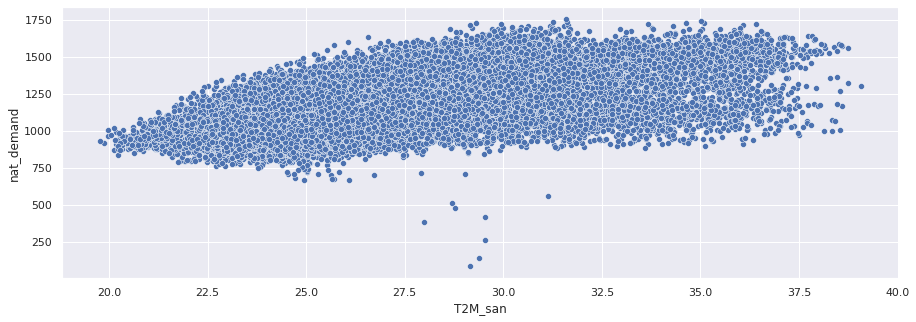

In [ ]:
sns.set(rc={'figure.figsize':(15,5)})
#---------------std & mean -----------
# summarize
print('mean=%.3f stdv=%.3f' % (np.mean(df_time['nat_demand']), np.std(df_time['T2M_san'])))
# plot
sns.scatterplot(x=df_time['T2M_san'], y=df_time['nat_demand'])

# Distribution Over Week 

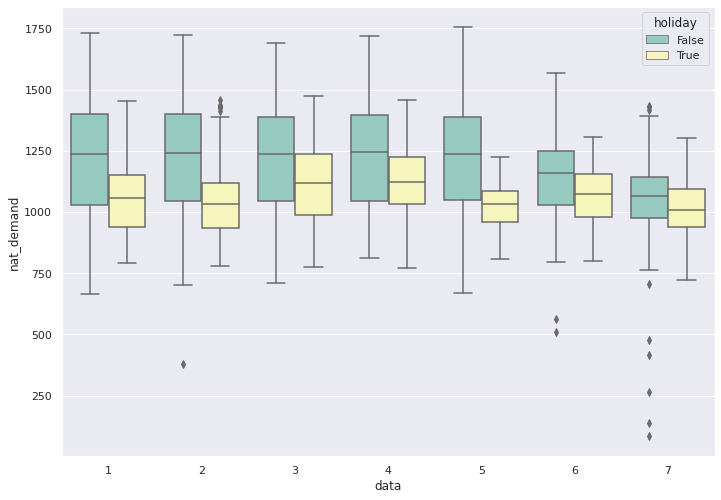

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x=df_time.data.dt.dayofweek +1, y="nat_demand", hue="holiday",  data=df_time, palette="Set3") 

# Distribution Over Daily Time 

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', length=48048)


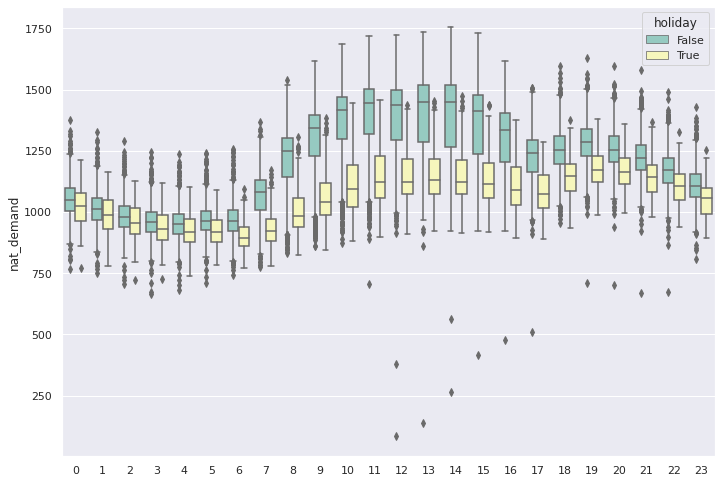

In [ ]:
print(df_time.index.hour)
ax = sns.boxplot(x=df_time.index.hour, y="nat_demand", hue="holiday",  data=df_time, palette="Set3") 

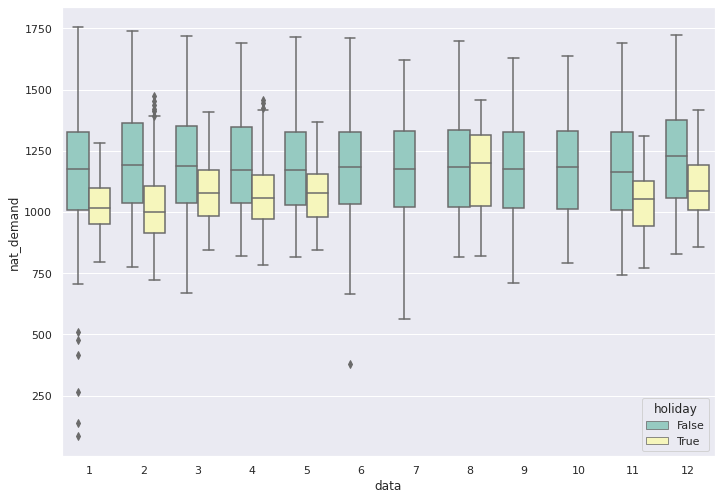

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x=df_time.data.dt.month, y="nat_demand", hue="holiday",  data=df_time, palette="Set3") 

# Esempio Luca 

In [ ]:
mod = sm.tsa.SARIMAX(df_time['nat_demand'], order = (1,0,0), trend='ct')
res = mod.fit()
  
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:             nat_demand   No. Observations:                48048
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -264219.521
Date:                Tue, 07 Dec 2021   AIC                         528447.041
Time:                        10:25:40   BIC                         528482.161
Sample:                    01-03-2015   HQIC                        528458.063
                         - 06-27-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     56.3923      1.953     28.877      0.000      52.565      60.220
drift          0.0001   2.03e-05      5.172      0.000    6.52e-05       0.000
ar.L1          0.9502      0.002    575.634      0.0

In [ ]:
print(res.forecast())

print(res.forecast(steps=10))

2020-06-27 01:00    1024.525936
Freq: H, dtype: float64
2020-06-27 01:00    1024.525936
2020-06-27 02:00    1034.937907
2020-06-27 03:00    1044.831392
2020-06-27 04:00    1054.232215
2020-06-27 05:00    1063.164914
2020-06-27 06:00    1071.652805
2020-06-27 07:00    1079.718042
2020-06-27 08:00    1087.381678
2020-06-27 09:00    1094.663714
2020-06-27 10:00    1101.583156
Freq: H, dtype: float64


In [ ]:
f_cast_res1 = res.get_forecast()
print(f_cast_res1.summary_frame(alpha=.10)) #0.10 -> 90% di confidenza 

nat_demand               mean    mean_se  mean_ci_lower  mean_ci_upper
2020-06-27 01:00  1024.525936  59.152231     927.229174    1121.822698


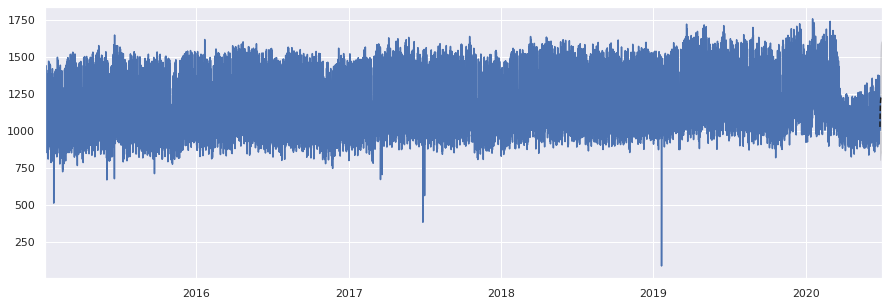

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))

df_time['nat_demand'].plot(ax=ax)

fcast = res.get_forecast(steps=100).summary_frame()

fcast['mean'].plot(ax=ax , style = 'k--')
ax.fill_between(fcast.index , fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k' , alpha=0.1)

# Test ADF (ipotesi nulla) & Auto Correlation 

In [ ]:
#df_time['nat_demand'] =df_time['nat_demand']/10
#df_time.head()

ADF statistic -20.961750007296537
P-Value 0.0


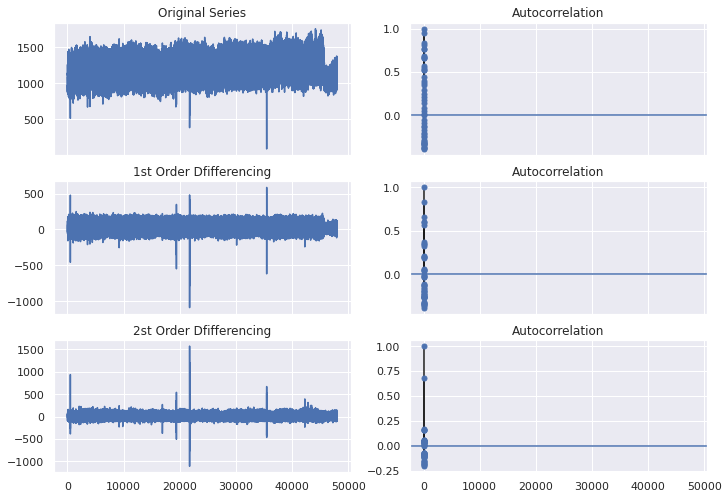

In [ ]:


_result = adfuller(df_time['nat_demand'])

print('ADF statistic {}'.format(_result[0]))
print('P-Value {}'.format(_result[1]))

#dato che il p-value è più piccolo di 0,05 non serve nessuna differenziazione 


s = df_time['nat_demand']
#print(df_time)
s1 = s.diff()
s2 = s1.diff()
#print(s1)


fig, axs = plt.subplots(3,2, sharex=True)
axs[0,0].plot(df_time['nat_demand'].values)
axs[0,0].set_title('Original Series')
plot_acf(df_time['nat_demand'].values, ax = axs[0,1])

axs[1,0].plot(s1.values)
axs[1,0].set_title('1st Order Dfifferencing')
plot_acf(s1.dropna().values, ax = axs[1,1])

axs[2,0].plot(s2.values)
axs[2,0].set_title('2st Order Dfifferencing')
plot_acf(s2.dropna().values, ax = axs[2,1])
plt.show()

KeyboardInterrupt: ignored

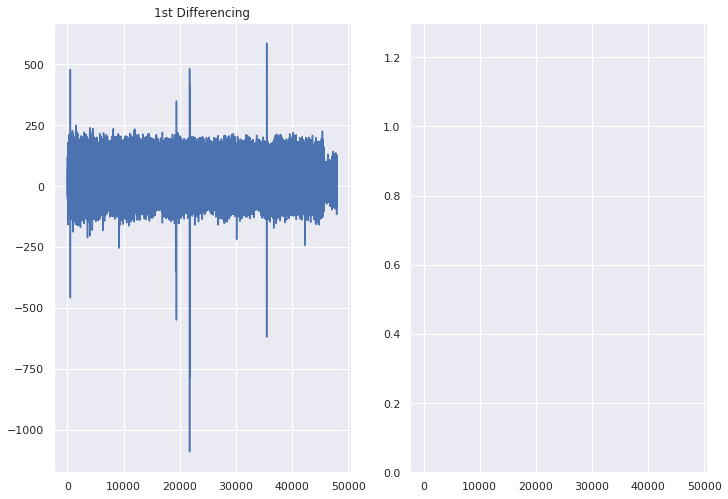

In [ ]:
fig, axs = plt.subplots(1,2, sharex=True)
axs[0].plot(s1.values) 
axs[0].set_title('1st Differencing')
axs[1].set(ylim=(0,1.3))
plot_pacf(s1.dropna().values, lags=400,  ax = axs[1])
plt.show()

In [ ]:
fig, axs = plt.subplots(1,2, sharex=True)
axs[0].plot(s1.values) 
axs[0].set_title('1st Differencing')
axs[1].set(ylim=(0,1.2))
plot_acf(s1.dropna().values,  lags=400, ax = axs[1])
plt.show()

# Actual VS Fitted 

In [ ]:
model_fit.plot_predict(dynamic=False)
plt.show()

# Metriche di Valutazione 

In [ ]:
def forecast_accuracy (forecast, actual): 
  mape = np.mean(np.abs(forecast-actual)/np.abs(actual)) #mape
  me = np.mean(forecast - actual)
  mae = np.mean(np.abs(forecast - actual))
  mpe = np.mean((forecast-actual)/actual)
  rmse = np.mean((forecast-actual)**2)**.5
  corr = np.corrcoef(forecast, actual)[0,1] 
  mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
  maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)

  minmax = 1 - np.mean(mins/maxs)

  #acf1 = acf(fc-test)[1]

  return({'mape':mape, 
          'me':me,  
          'mae':mae,
          'mpe':mpe,
          'rmse':rmse,
          #'acf1':acf1,
          'corr':corr,
          'minmax':minmax})

# ARIMA 

In [ ]:
# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = ARIMA(df_time['nat_demand'].values, order=(1,0,1)) 
ax = plt.gca()
results = model.fit() 
plt.plot(df_time['nat_demand'].values)
results.plot_predict
plt.plot(results.fittedvalues, color='red')
ax.legend(['Nat Demand', 'Forecast'])
results.summary()

In [ ]:
residui = pd.DataFrame(results.resid) #arima 
#residui = pd.DataFrame(res.resid) #sarimax 
fig, ax = plt.subplots(1,2)
residui.plot(title = 'Residui', ax = ax[0])
residui.plot(kind = 'kde' , title = 'Density' , ax = ax[1])
plt.show()

#Gli errori residui sembrano contenuti con media -> 0 e varianza uniforme 

In [ ]:
results.plot_predict(dynamic=False)
plt.show()

#SARIMA 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         nat_demand   No. Observations:                48048
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 12)   Log Likelihood             -285719.610
Date:                            Tue, 07 Dec 2021   AIC                         571451.221
Time:                                    12:29:11   BIC                         571503.901
Sample:                                         0   HQIC                        571467.753
                                          - 48048                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     56.3861      0.377    149.572      0.000      55.647      57.125
drift         -0.0017   1.28e-05   -132.698      0.000      -0.002      -0.002
ar.L1          0.9500      0.001   1059.394      0.000       0.948       0.952
ar.S.L12       0.9660      0.000   2995.724      0.000       0.965       0.967
ma.S.L12      -0.3669      0.003   -125.776      0.000      -0.373      -0.361
sigma2      3499.6650     14.327    244.272      0.000    3471.585    3527.745
===================================================================================
Ljung-Box (Q):                   292871.53   Jarque-Bera (JB):            454036.31
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

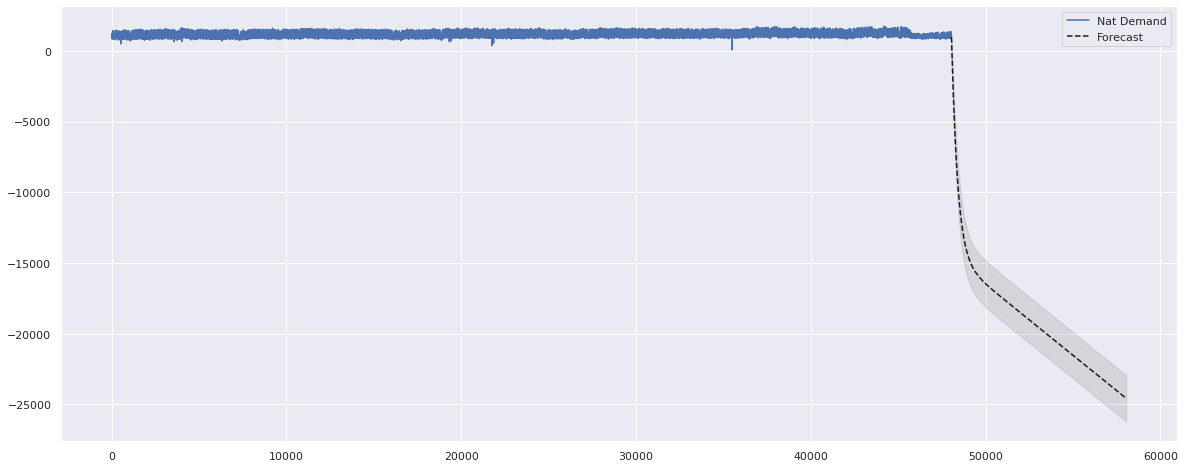

In [ ]:
import numpy as np
import statsmodels.api as sm 

# fit ARIMA model
fig = plt.figure(figsize=(20,8))
model = sm.tsa.SARIMAX(df_time['nat_demand'], seasonal_order = (1,0,1,12), trend='ct')  #...erano solo alcuni test, va rimesso order con (1,0,1)
#model = sm.tsa.SARIMAX(df_time['nat_demand'], order = (1,0,1), trend='ct')
ax = plt.gca()
results = model.fit() 
plt.plot(df_time['nat_demand'].values)

fcast = results.get_forecast(steps=10000).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

ax.legend(['Nat Demand', 'Forecast'])
results.summary()

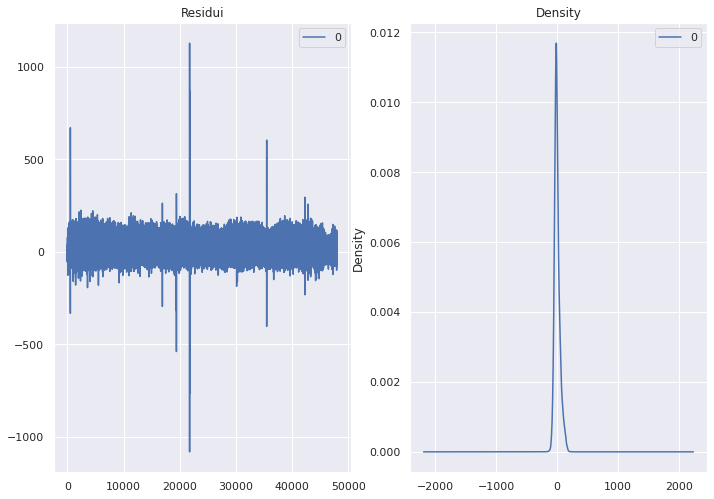

In [ ]:
residui = pd.DataFrame(results.resid) #arima 
#residui = pd.DataFrame(res.resid) #sarimax 
fig, ax = plt.subplots(1,2)
residui.plot(title = 'Residui', ax = ax[0])
residui.plot(kind = 'kde' , title = 'Density' , ax = ax[1])
plt.show()

#Gli errori residui sembrano contenuti con media -> 0 e varianza uniforme 

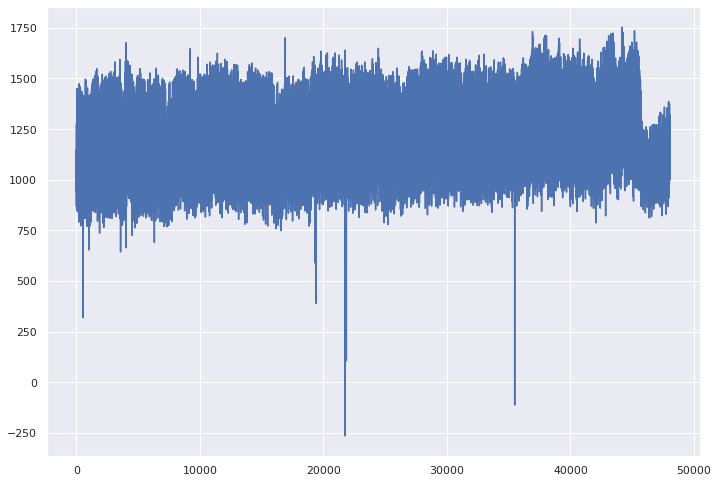

In [ ]:
results.predict().plot()# .plot_predict(dynamic=False)
plt.show()

# CROSS VALIDATION

                           Statespace Model Results                           
Dep. Variable:             nat_demand   No. Observations:                48048
Model:               SARIMAX(1, 0, 1)   Log Likelihood             -253081.666
Date:                Mon, 06 Dec 2021   AIC                         506173.331
Time:                        22:38:21   BIC                         506217.231
Sample:                             0   HQIC                        506187.108
                              - 48048                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     34.9773      2.516     13.903      0.000      30.046      39.908
drift          0.0003   2.91e-05     10.307      0.000       0.000       0.000
ar.L1          0.9627      0.002    447.100      0.0

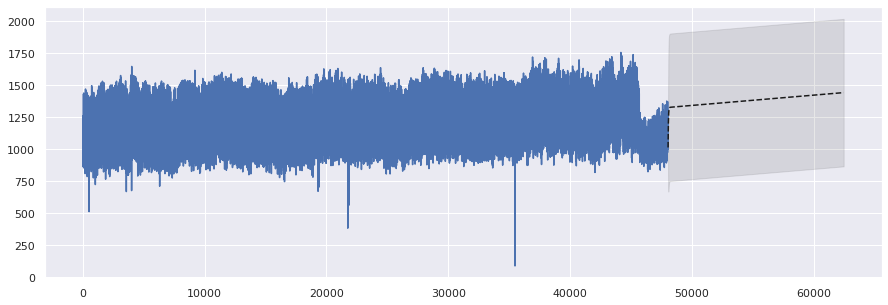

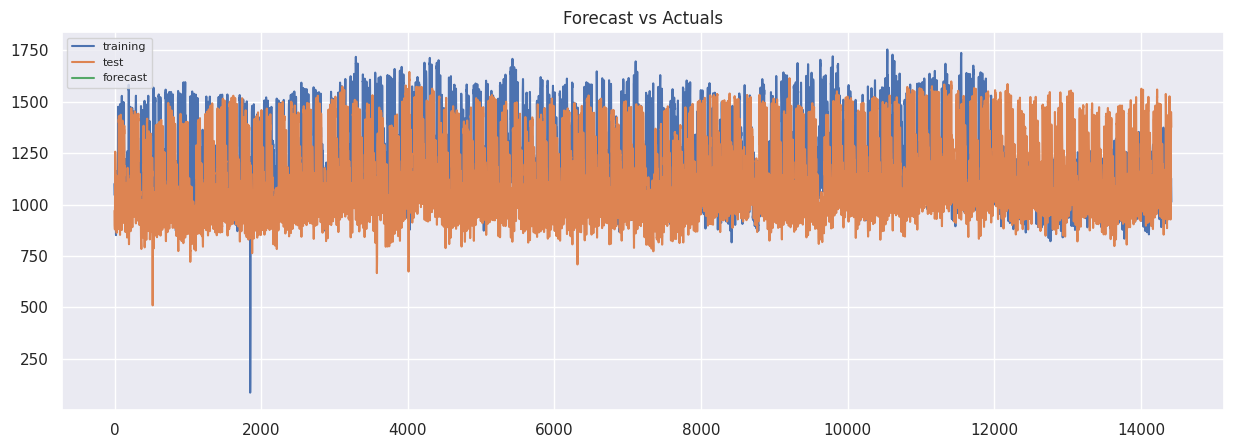

ARIMA METRICS
14414
14414
14414
{'mape': 0.25697629880312356, 'me': 236.38801838304627, 'mae': 260.36909964592064, 'mpe': 0.24072399970010777, 'rmse': 305.6468664315944, 'corr': 0.1121390960674308, 'minmax': 0.187728865364015}


In [ ]:
from statsmodels.tsa.stattools import acf 
from sklearn.model_selection import train_test_split


dim_train = int(len(df_time)*70/100)
dim_test = int(len(df_time)*30/100)


train = df_time[dim_train:]
test = df_time[:dim_test]

#Modello 
model = sm.tsa.SARIMAX(df_time['nat_demand'], order = (1,0,1), trend='ct')
res = model.fit(disp=0)

print(res.summary())
#Forecast 

fig,ax = plt.subplots(figsize=(15,5))

df_time['nat_demand'].plot(ax=ax)

fcast = res.get_forecast(steps=dim_test).summary_frame()

fcast['mean'].plot(ax=ax , style = 'k--')
ax.fill_between(fcast.index , fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k' , alpha=0.1)
#fc, se, conf = model_fit.forecast(len(test), alpha=0.05) #alpha è il parametro di confidenza

#Pandas Series 
fc_series = pd.Series(fcast['mean'], index=test.index)
lower_series = pd.Series(fcast['mean_ci_lower'], index=test.index)
upper_series = pd.Series(fcast['mean_ci_upper'], index=test.index)

#plot 
plt.figure(figsize =(15,5), dpi=100)
plt.plot(train['nat_demand'].values, label='training')
plt.plot(test['nat_demand'].values, label='test')
plt.plot(fc_series.values, label='forecast')
plt.fill_between(fc_series, lower_series, upper_series, color='g', alpha=0.5);
plt.title('Forecast vs Actuals')
plt.legend(loc = 'upper left', fontsize=8)
plt.show()



print('ARIMA METRICS')
print(dim_test)
print(len(fcast['mean'].values))
print(len(test['nat_demand'].values))
print(forecast_accuracy(fcast['mean'].values, test['nat_demand'].values))#train['nat_demand']


# Vecchie cose

In [ ]:
# The default is to get a one-step-ahead forecast:
print(res.forecast())

2015-03-06 14:00    1487.104668
Freq: H, dtype: float64


In [ ]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast()

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

nat_demand               mean    mean_se  mean_ci_lower  mean_ci_upper
2015-03-06 14:00  1487.104668  60.486476    1387.613269    1586.596067


In [ ]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy
from pandas import datetime
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# seasonal difference
X = df_time['nat_demand'].values
days_in_year = 365
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(1,1,1))
model_fit = model.fit()
# one-step out of sample forecast
start_index = len(differenced)
end_index = len(differenced)
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, days_in_year)
print('Forecast: %f' % forecast)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


Forecast: 1178.667468


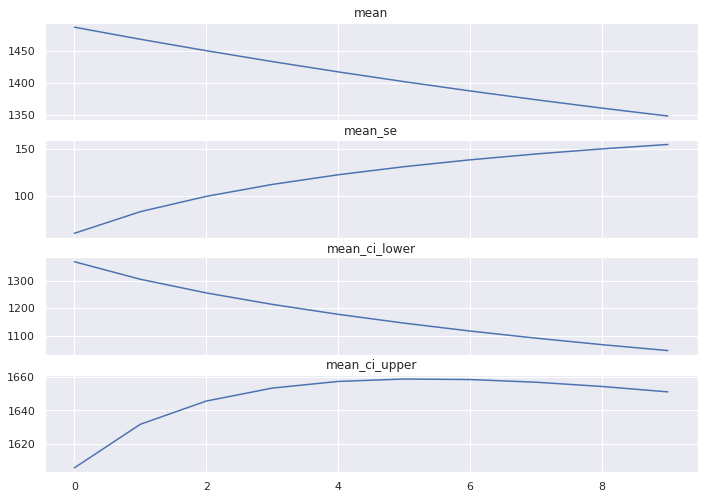

nat_demand               mean     mean_se  mean_ci_lower  mean_ci_upper
2015-03-06 14:00  1487.104668   60.486476    1368.553354    1605.655982
2015-03-06 15:00  1468.225096   83.388446    1304.786745    1631.663446
2015-03-06 16:00  1450.309490   99.605179    1255.086926    1645.532054
2015-03-06 17:00  1433.308697  112.222249    1213.357130    1653.260264
2015-03-06 18:00  1417.176071  122.478025    1177.123553    1657.228589
2015-03-06 19:00  1401.867344  131.029340    1145.054556    1658.680132
2015-03-06 20:00  1387.340505  138.278959    1116.318726    1658.362284
2015-03-06 21:00  1373.555685  144.497143    1090.346490    1656.764881
2015-03-06 22:00  1360.475049  149.876723    1066.722070    1654.228029
2015-03-06 23:00  1348.062690  154.561510    1045.127697    1650.997683


In [ ]:
fcast_res2 = res.get_forecast(steps=10)
fig, axs = plt.subplots(4,1, sharex=True)
axs[0].plot(fcast_res2.summary_frame()['mean'].values)
axs[0].set_title('mean')

axs[1].plot(fcast_res2.summary_frame()['mean_se'].values)
axs[1].set_title('mean_se')

axs[2].plot(fcast_res2.summary_frame()['mean_ci_lower'].values)
axs[2].set_title('mean_ci_lower')

axs[3].plot(fcast_res2.summary_frame()['mean_ci_upper'].values)
axs[3].set_title('mean_ci_upper')

plt.show()
# Note: since we did not specify the alpha parameter, the
# confidence level is at the default, 95%
print(fcast_res2.summary_frame())


In [ ]:
import datetime
print(res.get_forecast(start=datetime('2015-03-06'), end=datetime('2015-03-07')))

TypeError: ignored

In [ ]:

#transform datetime to index 


#transform datetime to index 
cols = dataframe.columns.to_numpy()
cols = np.append(cols, ['timeseries' , 'year', 'quarter'])
dataframe_timeserie = pd.DataFrame(columns=cols) 
print(dataframe_timeserie)

i = 0  

for index, row in dataframe.iterrows():  
  #print(row['datetime'])
  year = row['datetime'].split(sep='-')[0]
  quarter = int(row['datetime'].split(sep='-')[1])//4+1
  index_ = ('{}Q{}').format(year, quarter) 
  row['datetime'] = datetime.strptime(row['datetime'],'%Y-%m-%d %H:%M:%S')
  row = row.append(pd.Series({'timeseries':index_ , 'year' : year , 'quarter' : quarter}))
  
  dataframe_timeserie = dataframe_timeserie.append(row, ignore_index=True)
  i += 1
  if i > 10:
    break 


#dataframe_timeserie = dataframe_timeserie.set_index(['timeseries'])
print(dataframe_timeserie)


print('fine')

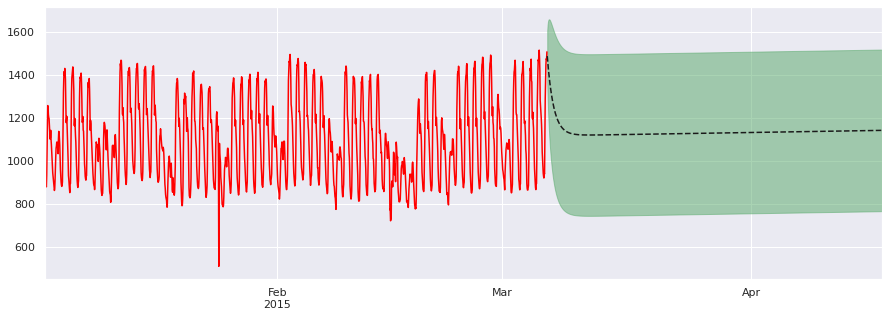

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

df_time2 = df_time.copy(deep=False)
#print(df_time2)

# Plot the data (here we are subsetting it to get a better look at the forecasts)
#df_time2['nat_demand'].iloc[:1500].plot(ax=ax, color='red')
df_time2['nat_demand'].plot(ax=ax, color='red')

# Construct the forecasts
fcast = res.get_forecast(steps=1000).summary_frame()
fcast['mean'].plot(ax=ax, style='k--' , label='mean')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='g', alpha=0.5);
plt.show()

#Word Count Plot 

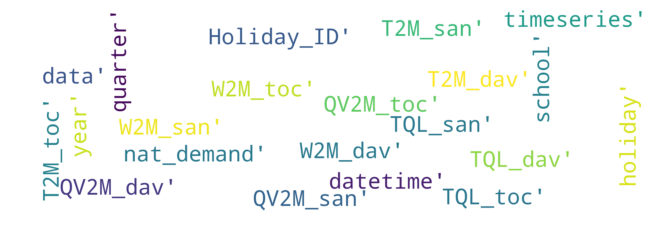

In [ ]:
text = df_time.columns
text = np.array2string(text.values)

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color='white', max_font_size=40, scale=3, height=400, width=1200).generate(text)

wordcloud.to_file("/content/drive/MyDrive/ProgettoDS/wordcloud.png")

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()